In [27]:
from langgraph.graph import StateGraph,START,END
from dotenv import load_dotenv
from typing import TypedDict,Annotated
from langchain_google_genai import  ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
import operator

In [28]:
import os
load_dotenv()
api_key=os.getenv("GOOGLE_API_KEY")

In [29]:
model=ChatGoogleGenerativeAI(
    api_key=api_key,
    model="gemini-2.5-flash"
)

In [30]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description="give a crisp feedback of the essay")
    score: int = Field(description="give a score out of 10 for the essay", ge=0, le=10)

structured_model=model.with_structured_output(EvaluationSchema)

In [31]:
class UPSCState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback:str
    clarity_feedback:str
    overall_feedback:str
    individual_scores: Annotated[list[int], operator.add]
    average_score: float


In [32]:
def evaluate_language(state: UPSCState):
    prompt=f"evaluate the language quality of the following essay and provide a feedback + a score from 0 to 10 : {state['essay']}"
    output=structured_model.invoke(prompt)
    return {"language_feedback": output.feedback,"individual_scores": [output.score]}

In [33]:
def evaluate_analysis(state: UPSCState):
    prompt=f"evaluate the depth of analysis of the following essay and provide a feedback + a score from 0 to 10 : {state['essay']}"
    output=structured_model.invoke(prompt)
    return {"analysis_feedback": output.feedback,"individual_scores": [output.score]}

In [34]:
def evaluate_clarity(state: UPSCState):
    prompt=f"evaluate the clarity of thoughts of the following essay and provide a feedback + a score from 0 to 10 : {state['essay']}"
    output=structured_model.invoke(prompt)
    return {"clarity_feedback": output.feedback,"individual_scores": [output.score]}

In [40]:
def evaluate_overall(state: UPSCState):
    prompt= f"Based on the following feedback create a summarized feedback: \n Language Feedback: {state['language_feedback']} \n Analysis Feedback: {state['analysis_feedback']} \n Clarity Feedback: {state['clarity_feedback']} "
    output=model.invoke(prompt).content

    avg_score=round(sum(state['individual_scores'])/len(state['individual_scores']),2)
    return {"overall_feedback":output,"average_score":avg_score}


In [36]:
graph=StateGraph(UPSCState)
graph.add_node("evaluate_language",evaluate_language)
graph.add_node("evaluate_analysis",evaluate_analysis)
graph.add_node("evaluate_clarity",evaluate_clarity)
graph.add_node("evaluate_overall",evaluate_overall)

graph.add_edge(START,"evaluate_language")
graph.add_edge(START,"evaluate_analysis")
graph.add_edge(START,"evaluate_clarity")
graph.add_edge("evaluate_language","evaluate_overall")
graph.add_edge("evaluate_analysis","evaluate_overall")
graph.add_edge("evaluate_clarity","evaluate_overall")
graph.add_edge("evaluate_overall",END)

workflow=graph.compile()

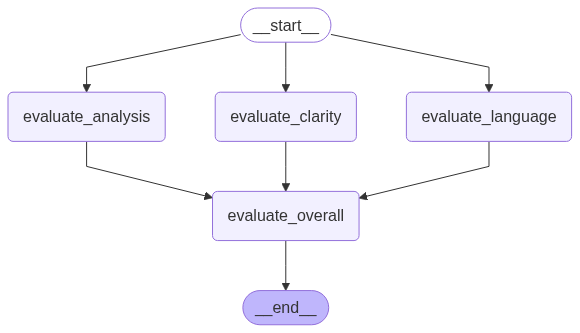

In [37]:
workflow

In [41]:
Myessay='''A best friend is someone who understands you completely, supports you in every situation, and makes life brighter with their presence. Among all the people I know, my best friend stands out as a constant source of joy, trust, and inspiration.
My best friend's name is Rohan. We have known each other since the first day of school, and over the years, our bond has grown stronger. He is kind, honest, and always ready to help others. What I admire most about him is his positive attitude, even when things do not go as planned. His cheerful smile can instantly lift my mood, and his wise advice has guided me through many difficult situations.
We share many interests, such as playing football, reading adventure novels, and exploring new places. Whenever we spend time together, it is filled with laughter, learning, and unforgettable memories. Rohan is also a great listener. I can talk to him about anything without fear of being judged. He keeps my secrets safe and encourages me to be a better person every day.
One of the most memorable moments with my best friend was when we participated in a science competition. We worked together for weeks, supported each other during stressful times, and eventually won first place. That experience not only brought us closer but also taught us the value of teamwork and trust.
In conclusion, my best friend is more than just a companion; he is like a brother to me. I feel lucky to have someone who stands by my side through thick and thin. True friendship is rare, and I cherish ours deeply. I hope our bond lasts forever, because life feels incomplete without a best friend like Rohan.
'''
initial_state={
    "essay":Myessay
}
final_state=workflow.invoke(initial_state)
print(final_state["overall_feedback"])
print(final_state['individual_scores'])
print(final_state["average_score"])

Here's a summarized feedback based on the provided points:

The essay is highly commended for its **strong writing quality and clarity**. It is well-written, clear, and heartfelt, effectively using descriptive language and personal anecdotes to convey the importance of friendship. The structure is logical, well-organized, and ensures a smooth, easy-to-follow progression of ideas.

While the essay excels in describing your bond with your friend, the primary area for growth lies in **deepening the analytical aspect**. Currently, it is more descriptive than critically analytical. To enhance this, consider exploring *why* certain qualities of friendship are crucial, *how* specific events shaped your understanding of the bond, or what *universal aspects* of friendship your unique relationship illuminates.
[7, 9, 8]
8.0
